In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
import numpy as np
from copy import copy
import matplotlib.pyplot as plt

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Construction du maillage

On construit le maillage, qui contient deux bobine dans un carré d'air.

In [2]:
geo = SplineGeometry()

geo.AddRectangle(p1=(-3,-3),p2=(3,3),bc="rectangle",leftdomain=1,rightdomain=0,
                 bcs = ("right", "top", "left", "bot"))
geo.AddRectangle(p1=(-1.1,-0.2), p2=(-1,0.2),bc="rectangle",leftdomain=2,rightdomain=1)
geo.AddRectangle(p1=(-0.6,-0.2),p2=(-0.5,0.2),bc="rectangle",leftdomain=3,rightdomain=1)
geo.AddRectangle(p1=(0.5,-0.2),p2=(0.6,0.2),bc="rectangle",leftdomain=4,rightdomain=1)
geo.AddRectangle(p1=(1,-0.2),p2=(1.1,0.2),bc="rectangle",leftdomain=5,rightdomain=1)

geo.SetMaterial (1, "zone_optim")
geo.SetMaterial (2, "primaire_p")
geo.SetMaterial (3, "primaire_m")
geo.SetMaterial (4, "secondaire_p")
geo.SetMaterial (5, "secondaire_m")

#geo.SetDomainMaxH(1, 0.05)
ngmesh = geo.GenerateMesh(maxh=0.2)
mesh = Mesh(ngmesh)
Draw(mesh)
#mesh.GetBoundaries()

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'dr…

BaseWebGuiScene

# 2) Formulation variationnelle

L'équation magnétostatique s'écrit en 2D :

$$ \text{div}(\nu ~ \overrightarrow{\text{grad}} ~ a_z) = j_z  $$

On choisit des conditions limites de Dirichlet homogène. Le problème sous forme faible s'écrit alors :

$$ \text{Trouver}~ a_z \in H^1_0 = \{ a \in H^1, a = 0 ~\text{sur}~ \partial \Omega \},\quad \text{tel que}~ \forall \phi \in H^1_0,$$

$$ \underbrace{\int_\Omega \overrightarrow{\text{grad}} ~ \phi . \nu~ \overrightarrow{\text{grad}} ~ a_z}_{\text{forme bilinéaire}} = \underbrace{\int_\Omega \phi j_z}_{\text{forme linéaire}}$$

In [3]:
J= 1e6;

def solveDirect(nu):
    
    # 1) définition de l'espace fonctionnel
    
    fespace_H1 = H1(mesh, order=1, dirichlet="right|top|left|bot")
    a = fespace_H1.TrialFunction()
    phi = fespace_H1.TestFunction()

    # 2) Définition de la forme linéaire
    
    l = LinearForm(fespace_H1)
    l += phi*J*dx("primaire_p") - phi*J*dx("primaire_m")
    

    # 2) Définition de la forme bilinéaire
    
    K = BilinearForm(fespace_H1, symmetric=True)
    K += grad(phi)*nu*grad(a)*dx
    
    # 3) Assemblage -> on sort du monde continu pour discrétiser et résoudre !
    
    l.Assemble()
    K.Assemble()
    
    # 4) Résolution
    
    direct_state = GridFunction(fespace_H1)  # solution
    direct_state.vec.data =     K.mat.Inverse(inverse="sparsecholesky",
                                              freedofs=fespace_H1.FreeDofs()) * l.vec
    
    return direct_state

# 3) Définition des variables d'optimisation

Les variables d'optimisation seront des "densités"; à chaque densité est attribué une réluctivité magnétique. Comme ces densités ne sont pas continues, on les choisit dans l'espace $\mathcal{L}^2$.

In [4]:
# Définition des variables d'optimisation


fespace_rho = L2(mesh, order=0)
 
rho = GridFunction(fespace_rho)
rho.vec[:] = 0.5
#rho.vec[:] = 0.2*np.random.randint(0,5,len(rho.vec[:].FV().NumPy()))

bobine = mesh.MaterialCF({ "secondaire_p" : 1, "secondaire_m" : 1,
                      "primaire_p" : 1, "primaire_m" : 1}, default=0)
mask = GridFunction(fespace_rho)
mask.Set(bobine)
rho.vec.FV().NumPy()[mask.vec.FV().NumPy()[:]==1] = 0.5


# Définition de la pénalisation

p = 1
nu0 = 1/(4e-7*3.14)
nu_fer = nu0/1000

def rho2nu(rho):
    nu = copy(rho)
    nu.vec[:] = nu0 + (nu_fer-nu0) * np.power(rho.vec.FV().NumPy(),p)
    
    bobine = mesh.MaterialCF({ "secondaire_p" : 1, "secondaire_m" : 1,
                      "primaire_p" : 1, "primaire_m" : 1}, default=0)

    mask = GridFunction(fespace_rho)
    mask.Set(bobine)
    nu.vec.FV().NumPy()[mask.vec.FV().NumPy()[:]==1] = 1/(4e-7*pi)
    
    return nu

# Résolution du problème

nu = rho2nu(rho)
sol = solveDirect(nu)
Draw(rho)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

# 4) Calcul de la fonction objectif et de sa *dérivée*

Avec ce qui précède, on est capable de calculer l'état physique $a_z$ du système, ce qui permet de calculer la fonction objectif $\mathcal{F}(a_z)$ de notre problème, qu'on souhaite minimiser. Dans notre cas, on souhaite maximiser le flux magnétique $\phi$ qui traverse la bobine secondaire. Le flux magnétique traversant un segment délimité par deux points $A$ et $B$ est directement proportionnel à la différence de $a_z$ entre ces deux points. On peut alors en déduire la fonction objectif suivante :

$$ \mathcal{F}(a_z) = \int_{s+} a_z  -   \int_{s-} a_z $$

Où $s+$ et $s-$ représentent les surfaces des conducteurs positifs et négatifs, respectivement.

In [5]:
def objectiveFunction(az):
    return -Integrate ( az, mesh.Materials("secondaire_m")) + Integrate ( az, mesh.Materials("secondaire_p"))

print(objectiveFunction(sol))

-7.263572267725331e-05


Il ne reste plus qu'à calculer la dérivée de cette fonction objectif par rapport à la fonction densité $\rho$, qui joue le rôle de variable d'optimisation. La dépendance de $\mathcal{F}$ par rapport à $\rho$ se fait implicitement au travers de $a_z$. Le problème, c'est qu'on n'a pas d'expression de $a_z(\rho)$.
On utilise alors la méthode de l'adjoint : on introduit un langrangien $\mathcal{L}$ qui s'écrit pour toutes variables indépendantes $\tilde{\rho}, \tilde{a_z}, \tilde{p} \in \mathcal{L}^2(\Omega) \times H^1_0(\Omega) \times H^1_0(\Omega) $ :
$$ \mathcal{L}(\tilde{\rho}, \tilde{a_z}, \tilde{p}) = \overbrace{\mathcal{F}(\tilde{a_z})}^{\text{fonction objectif}} + \underbrace{\int_\Omega \overrightarrow{\text{grad}} ~ \tilde{p} . \nu(\tilde{\rho})~ \overrightarrow{\text{grad}} ~ \tilde{a_z} - \int_\Omega \tilde{p} j_z}_{\text{formulation variationnelle}} $$ 

Cela permet d'introduire un degré de liberté supplémentaire. En effet :

$$ \forall \tilde{p} \in H^1_0(\Omega), \quad \mathcal{F}(a_z(\rho)) = \mathcal{L}(a_z, \rho, \tilde{p} )$$

La règle de la chaîne permet d'affirmer que :

$$ \mathrm{d}_\rho \mathcal{F}(a_z(\rho)) = \mathrm{d}_\rho \mathcal{L}(a_z,\rho,\tilde{p}) = \underbrace{\partial_\rho \mathcal{L}(a_z,\rho,\tilde{p})}_{\text{dérivée partielle, calculable}} + \overbrace{\partial_{a_z} \mathcal{L}(a_z,\rho,\tilde{p})}^{\text{dérivée partielle, calculable}} . \underbrace{\mathrm{d}_\rho a_z}_{\text{???}} $$

On ne connaît pas le terme $\mathrm{d}_\rho a_z$ (*en toute rigueur, on ne sait même pas si il existe et donc si cette expression à un sens*). En revanche, on peut utiliser le degré de liberté supplémentaire $\tilde{p}$ pour annuler le terme $\partial_a \mathcal{L}(a_z,\rho,\tilde{p})$, ce qui permet de résoudre formellement le problème.

 - La dérivée fonctionnelle par rapport à $\tilde{p}$ donne la formulation variationnelle associée à l'état physique $a_z$, qui est annulée lorsque $\tilde{a_z} = a_z$ :
$$ \forall \phi \in H^1_0(\Omega), \quad  \langle \partial_{\tilde{p}} \mathcal{L},\phi\rangle = \int_\Omega \overrightarrow{\text{grad}} ~ \phi . \nu(\tilde{\rho})~ \overrightarrow{\text{grad}} ~ \tilde{a_z} - \int_\Omega \phi j_z$$

- La dérivée fonctionnelle par rapport à $\tilde{a_z}$ donne la formulation variationnelle associée à l'état adjoint $p$, qui est annulée lorsque $\tilde{p} = p$ :
$$ \forall \phi \in H^1_0(\Omega), \quad  \langle \partial_{\tilde{a_z}} \mathcal{L},\phi \rangle = \underbrace{\int_{s-} \phi - \int_{s+} \phi}_{ \partial_{\tilde{a_z}} \mathcal{F}} +\int_\Omega \overrightarrow{\text{grad}} ~ \tilde{p} . \nu(\tilde{\rho})~ \overrightarrow{\text{grad}} ~ \phi  $$

- La dérivée fonctionnelle par rapport à $\tilde{\rho}$ :
$$ \forall \phi \in H^1_0(\Omega), \quad  \langle \partial_{\tilde{\rho}} \mathcal{L},\phi \rangle = \int_\Omega \overrightarrow{\text{grad}} ~ \tilde{p} . \partial_{\tilde{\rho}} \nu(\tilde{\rho})~ \overrightarrow{\text{grad}} ~ \tilde{a_z} \phi $$

On peut procéder ensuite à une identification $\mathcal{L}^1$ pour trouver une *direction de descente* en $\tilde{a_z} = a_z$, $\tilde{\rho} = \rho$ et surtout $\tilde{p} = p$. Autrement dit, il faut trouver $\phi$ tel que $\langle \partial_{\rho} \mathcal{L},\phi \rangle < 0 $. Une garantie pour cela est de choisir : 
$$\phi \propto - \overrightarrow{\text{grad}} ~ p . \partial_{\rho} \nu(\rho)~ \overrightarrow{\text{grad}} ~ a_z$$

In [6]:
def solveAdjoint(nu):
    # 1) définition de l'espace fonctionnel
    
    fespace_H1 = H1(mesh, order=1, dirichlet="right|top|left|bot")
    p = fespace_H1.TrialFunction()
    phi = fespace_H1.TestFunction()

    # 2) Définition de la forme linéaire
    
    l = LinearForm(fespace_H1)
    l += -phi*dx("secondaire_m") + phi*dx("secondaire_p")
    

    # 2) Définition de la forme bilinéaire
    
    K = BilinearForm(fespace_H1, symmetric=True)
    K += grad(p)*nu*grad(phi)*dx
    
    # 3) Assemblage -> on sort du monde continu pour discrétiser et résoudre !
    
    l.Assemble()
    K.Assemble()
    
    # 4) Résolution
    
    adjoint_state = GridFunction(fespace_H1)  # solution
    adjoint_state.vec.data =     K.mat.Inverse(inverse="sparsecholesky",
                                              freedofs=fespace_H1.FreeDofs()) * l.vec
    
    return adjoint_state

adjoint = solveAdjoint(nu)
Draw(adjoint)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

In [7]:
def dnudrho(rho):
    dnu = copy(rho)
    dnu.vec[:] = nu0 + (nu_fer-nu0) * p * np.power(rho.vec.FV().NumPy(),p-1)
    
    bobine = mesh.MaterialCF({ "secondaire_p" : 1, "secondaire_m" : 1,
                      "primaire_p" : 1, "primaire_m" : 1}, default=0)

    mask = GridFunction(fespace_rho)
    mask.Set(bobine)
    dnu.vec.FV().NumPy()[mask.vec.FV().NumPy()[:]==1] = 0
    
    return dnu

def descentDirection(direct_state,adjoint_state,rho):
    return - grad(adjoint_state) * dnudrho(rho) * grad(direct_state)

# 5) Boucle d'optimisation 
Maintenant qu'on sait calculer la fonction objectif et une direction de descente, il n'y a plus qu'à les incorporer dans un algorithme d'optimisation.

In [8]:
objFuncList = []
rhoList = []
descentList = []
step = 0.1
descent = GridFunction(fespace_rho)

for i in range(100):
    
    # Calculs état direct, adjoint et direction de descente
    nu = rho2nu(rho)
    direct_state = solveDirect(nu)
    adjoint_state = solveAdjoint(nu)
    descent.Set(descentDirection(direct_state,adjoint_state,rho))
    descent.vec[:] = np.sign(descent.vec[:].FV().NumPy())
    
    rhoList.append(copy(rho))
    objFuncList.append(objectiveFunction(direct_state))
    descentList.append(copy(descent))
    
    print(f'{objFuncList[-1]} - step : {step}')
    
    if i>0 and objFuncList[-1]< objFuncList[-2]:
        step = step*1.2
    elif i>0:
        step = step/2
      
    rho.Set(rhoList[i] + descentList[i]*step)
    rho.vec[:].FV().NumPy()[rho.vec[:].FV().NumPy()<0]=0
    rho.vec[:].FV().NumPy()[rho.vec[:].FV().NumPy()>1]=1
    
    if np.isnan(np.sum(rho.vec[:].FV().NumPy())):
        break
    if step < 1e-4:
        break

-7.263572267725339e-05 - step : 0.1
-0.00013297542641240508 - step : 0.1
-0.00029628503211566107 - step : 0.12
-0.0010684202110535887 - step : 0.144
-0.27575367487328833 - step : 0.17279999999999998
-0.28068361480526666 - step : 0.20735999999999996
-0.2847266682956785 - step : 0.24883199999999994
-0.28483417661776367 - step : 0.29859839999999993
-0.28484606784600525 - step : 0.3583180799999999
-0.28504075967516007 - step : 0.4299816959999999
-0.2850407596751605 - step : 0.5159780351999999
-0.28504075967516634 - step : 0.6191736422399998
-0.2850407596751666 - step : 0.7430083706879997
-0.2850407596751603 - step : 0.8916100448255997
-0.2850407596751357 - step : 0.44580502241279985
-0.285040759675185 - step : 0.22290251120639992
-0.2850407596752528 - step : 0.2674830134476799
-0.2850407596751607 - step : 0.3209796161372159
-0.2850407596751789 - step : 0.16048980806860794
-0.2850407596751602 - step : 0.19258776968232952
-0.28504075967513615 - step : 0.09629388484116476
-0.28504075967518544

In [9]:
Draw(rho,mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

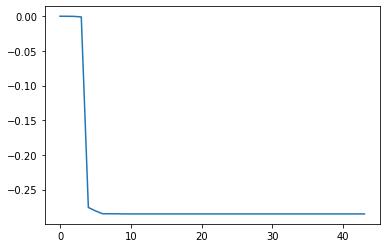

In [10]:
plt.plot(objFuncList)

In [11]:
def a2b(a):
    b_vec = GridFunction(L2(mesh, dim = 2))
    b_vec.Set(grad(direct_state))
    rot = np.array([[0,1],[-1,0]])
    n = len(b_vec.vec.FV().NumPy())
    vec = np.reshape(b_vec.vec.FV().NumPy(),(int(n/2),2)).transpose()
    b = (rot @ vec).transpose()
    b_vec.vec.FV().NumPy()[:] = np.reshape(b[:],(len(b)*2))
    return b_vec

Draw(a2b(direct_state),mesh,vectors = { "grid_size":20})

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene